In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_ENABLE_ONEDNN_OPTS'] =  "0"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

## Librerías
import seaborn as sns
import sys
import cv2 as cv2
import glob
from PIL import Image
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import gc
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import os


from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

print(tf.__version__)

2.14.0


In [3]:
## Uso de GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2023-10-23 21:36:21.570177: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-23 21:36:22.303228: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-23 21:36:22.303406: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
### Rutas de todas las imágenes

## Obtener todas las rutas de las imágenes en el dataset
ruta_dataset  = glob.glob('../../../Datasets/Humedas_Secas_procesadas/Recortadas/*/*/*/*.jpg')

## Capturar solo rutas secas 
rutas_imagenes_secas = []
rutas_imagenes_humedas = []

clases_secas= []
clases_humedas = []
for ruta in ruta_dataset:
    if ruta.split('/')[-2] == 'Secas' or ruta.split('/')[-2] == 'Seca':
        clases_secas.append(ruta.split('/')[-4])
        rutas_imagenes_secas.append(ruta)
    else:
        clases_humedas.append(ruta.split('/')[-4])
        rutas_imagenes_humedas.append(ruta)

## Construcción de datasets
data_secas = pd.DataFrame({'ruta':rutas_imagenes_secas,'clase':clases_secas})
data_humedas = pd.DataFrame({'ruta':rutas_imagenes_humedas,'clase':clases_humedas})

## reemplazo de etiquetas}
lables_generalization = {'CuNi1':'MF1','CuNi2':'MF2','CuNi3':'MF3'}
data_secas.replace(lables_generalization,inplace=True)
data_humedas.replace(lables_generalization,inplace=True)

## summary    
print('Imágenes secas:', np.shape(rutas_imagenes_secas)[0],' - Imágenes Húmedas: ',np.shape(rutas_imagenes_humedas)[0])
print('MF1:', '- secas: ', np.shape(data_secas[data_secas['clase']=='MF1'])[0], '- húmedas: ', np.shape(data_humedas[data_humedas['clase']=='MF1'])[0])
print('MF2:', '- secas: ', np.shape(data_secas[data_secas['clase']=='MF2'])[0], '- húmedas: ', np.shape(data_humedas[data_humedas['clase']=='MF2'])[0])
print('MF3:', '- secas: ', np.shape(data_secas[data_secas['clase']=='MF3'])[0], '- húmedas: ', np.shape(data_humedas[data_humedas['clase']=='MF3'])[0])

Imágenes secas: 931  - Imágenes Húmedas:  792
MF1: - secas:  379 - húmedas:  265
MF2: - secas:  289 - húmedas:  265
MF3: - secas:  263 - húmedas:  262


In [5]:
## Crear Dataframe
df_secas = pd.DataFrame()
df_secas['routes'] = rutas_imagenes_secas
df_secas['label'] = clases_secas

char_to_num = {'CuNi1':'0','CuNi2':'1','CuNi3':'2'}

df_secas['label'].replace(char_to_num,inplace=True)

## Recolver dataframe
df_secas = df_secas.sample(frac=1,random_state=42).reset_index(drop=True)
df_secas 

,routes,label
0,../../../Datasets/Humedas_Secas_procesadas/Rec...,0
1,../../../Datasets/Humedas_Secas_procesadas/Rec...,2
2,../../../Datasets/Humedas_Secas_procesadas/Rec...,0
3,../../../Datasets/Humedas_Secas_procesadas/Rec...,1
4,../../../Datasets/Humedas_Secas_procesadas/Rec...,0
...,...,...
926,../../../Datasets/Humedas_Secas_procesadas/Rec...,2
927,../../../Datasets/Humedas_Secas_procesadas/Rec...,1
928,../../../Datasets/Humedas_Secas_procesadas/Rec...,0
929,../../../Datasets/Humedas_Secas_procesadas/Rec...,1


In [6]:
## Establecer el porcentaje de separación
thold1 = int(np.ceil(0.8 * len(df_secas[df_secas.label=='0'])))
thold2 = int(np.ceil(0.8 * len(df_secas[df_secas.label=='1'])))
thold3 = int(np.ceil(0.8 * len(df_secas[df_secas.label=='2'])))

## Separar por clases para entrenamiento
train_cu1 = df_secas[df_secas.label == '0'][0:thold1]
train_cu2 = df_secas[df_secas.label == '1'][0:thold2]
train_cu3 = df_secas[df_secas.label == '2'][0:thold3]

## tomar las demás imágenes para test
test_cu1 = df_secas[df_secas.label == '0'][thold1:]
test_cu2 = df_secas[df_secas.label == '1'][thold2:]
test_cu3 = df_secas[df_secas.label == '2'][thold3:]


## Constuir un solo dataset de training
train_df =  pd.concat([pd.concat([train_cu1,train_cu2]),train_cu3]).sample(frac=1,random_state=42).reset_index(drop=True)

## Construir un solo dataset de test
test_df = pd.concat([pd.concat([test_cu1,test_cu2]),test_cu3]).sample(frac=1,random_state=42).reset_index(drop=True)

## Cantidad de muestras por clase
print('Clase MF1: train: ',len(train_cu1),', test: ',len(test_cu1))
print('Clase MF2: train: ',len(train_cu2),', test: ',len(test_cu2))
print('Clase MF3: train: ',len(train_cu3),', test: ',len(test_cu3))

Clase MF1: train:  304 , test:  75
Clase MF2: train:  232 , test:  57
Clase MF3: train:  211 , test:  52


In [7]:
def load_image(file_name):
  raw = tf.io.read_file(file_name)
  tensor = tf.io.decode_jpeg(raw,channels=1)
  tensor = tf.image.resize(tensor, [128,128])
  tensor = tf.cast(tensor, tf.float32) / 255.0
  print("Final shape: ", tensor.shape)
  return tensor

def create_dataset(file_names, labels):
  dataset = tf.data.Dataset.from_tensor_slices((file_names,labels))
  dataset.shuffle(buffer_size=16)
  dataset = dataset.map(lambda file_name, label: (load_image(file_name), label))
  
  return dataset

file_names = train_df['routes'].to_numpy()
labels = train_df['label'].to_numpy()
dataset = create_dataset(file_names, labels)

2023-10-23 21:36:33.787145: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-23 21:36:33.787406: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-23 21:36:33.787580: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Final shape:  (128, 128, 1)


(11, 128, 128, 1)
(11,)
tf.Tensor([b'0' b'1' b'0' b'2' b'0' b'2' b'0' b'0' b'0' b'1' b'0'], shape=(11,), dtype=string)
47


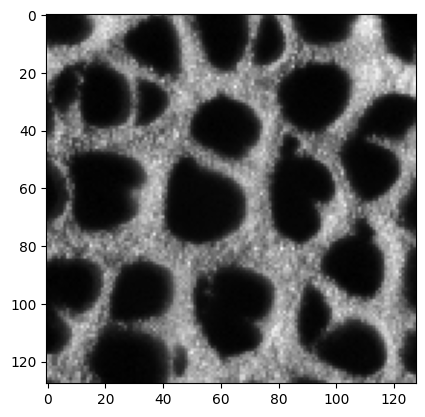

In [8]:
cnt = 0
for i in dataset.batch(16):
    cnt += 1
    a = i[0]
    b = i[1]


print(a.shape)
print(b.shape)
plt.imshow(a[0,:,:,0],cmap='gray')
print(b)
print(cnt)  

In [11]:
## Dataset de prueba
test_df = test_df.sample(frac=1,random_state=42).reset_index(drop=True)

X_test_secas = []
y_test_secas = []

nsize = 128

## Recorrerr rutas
for i in range(len(test_df)):
    
    #Capturar ruta y label
    ruta = test_df.iloc[i].routes
    label = test_df.iloc[i].label
    
    ##cargar imagen
    im = tf.keras.preprocessing.image.load_img(ruta,color_mode='grayscale')
    
    X_test_secas.append(tf.keras.preprocessing.image.img_to_array(im.resize((nsize,nsize))))
    y_test_secas.append(test_df.iloc[i].label)
    
print('Test: train->',np.shape(X_test_secas),' test ->',np.shape(y_test_secas))

Test: train-> (184, 128, 128, 1)  test -> (184,)


In [12]:
x_test_secas = np.array(X_test_secas)
x_test_secas= x_test_secas.astype('float32')
 
#y_test_secas = tf.keras.utils.to_categorical(y_test_secas)
#y_train_expanded = tf.keras.utils.to_categorical(y_train_expanded) 

#x_train_expanded /= 255
x_test_secas /= 255

print('Number of images in x_test', x_test_secas.shape, "y_test: ", np.shape(y_test_secas))

Number of images in x_test (184, 128, 128, 1) y_test:  (184,)


In [13]:
x_train = []
y_train_ten = []
for data,label in dataset.batch(8):
    x_train.extend(data[:].numpy())
    y_train_ten.extend(label)   

x_train = np.array(x_train)
x_train = x_train.astype('float32')

y_train= []
for i in y_train_ten:
    y_train.append(str(int(i)))

print(np.shape(x_train),np.shape(y_train))

(747, 128, 128, 1) (747,)


## Cargar modelo

In [14]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [15]:
encoder = keras.models.load_model('Models/GVAE_encoder_DRY_2_32.h5', custom_objects={'Sampling':Sampling})
decoder = keras.models.load_model('Models/GVAE_decoder_DRY_2_32.h5', custom_objects={'Sampling':Sampling})

2023-10-23 21:38:09.399296: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37748736 exceeds 10% of free system memory.


In [16]:
data_train = x_train
data_test = x_test_secas

label_train = y_train
label_test = y_test_secas

print('Train: ',np.shape(data_train),np.shape(label_train))
print('Test: ',np.shape(data_test),np.shape(label_test))

# Embebidos del encoder
encoder_embds  = encoder.predict(data_train)
print('Shape_embs: ',np.shape(encoder_embds))

# Embebidos del encoder
encoder_embds_test  = encoder.predict(data_test)
print('Shape_embs: ',np.shape(encoder_embds_test))

Train:  (747, 128, 128, 1) (747,)
Test:  (184, 128, 128, 1) (184,)


2023-10-23 21:38:11.513184: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48955392 exceeds 10% of free system memory.
2023-10-23 21:38:11.553146: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48955392 exceeds 10% of free system memory.
2023-10-23 21:38:36.654297: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-10-23 21:39:27.378195: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-10-23 21:39:27.379293: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available

24/24 [==============================] - 84s 142ms/step
Shape_embs:  (3, 747, 32)
6/6 [==============================] - 1s 294ms/step
Shape_embs:  (3, 184, 32)


## Classifiers

In [17]:
char_to_num_new = {'0':0,'1':1,'2':2}
char_to_num_new

{'0': 0, '1': 1, '2': 2}

In [23]:
np.shape(tf.keras.utils.to_categorical(label_train))

(747, 3)

In [25]:
## Embebidos
#--- Train
media_train = encoder_embds[0]
variance_train = encoder_embds[1]
z_train = encoder_embds[2]

#--- Test
media_test = encoder_embds_test[0]
variance_test = encoder_embds_test[1]
z_test = encoder_embds_test[2]

#--- labels
#labels_text_test
#labels_text
#images_df['label'].replace(char_to_num,inplace=True)

data_embs_train = pd.DataFrame()
data_embs_train ['mean'] =  media_train.tolist()
data_embs_train ['var'] =  variance_train.tolist()
data_embs_train ['z'] =  z_train.tolist()
data_embs_train ['labels'] = list(pd.DataFrame(label_train).replace(char_to_num_new).values.reshape(-1))

data_embs_test = pd.DataFrame()
data_embs_test ['mean'] =  media_test.tolist()
data_embs_test ['var'] =  variance_test.tolist()
data_embs_test ['z'] =  z_test.tolist()
data_embs_test ['labels'] = list(pd.DataFrame(label_test).replace(char_to_num_new).values.reshape(-1))

### Decision trees

In [87]:
estist = 'z'

max:  0.6739766081871345  - depth:  143
accuracy 0.662 (+/- 0.11864)


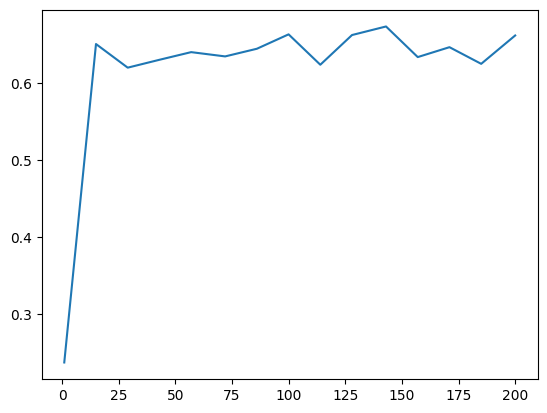

In [88]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import *

dpst = []
acs = []

for d in np.linspace(1,200,15, dtype=int):
    est_DT_mean = DecisionTreeClassifier(max_depth=d,random_state=42)

    x = list(data_embs_test[estist].values)
    y = tf.keras.utils.to_categorical(list(data_embs_test['labels'].values))

    s = cross_val_score(est_DT_mean, x,y, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
    acs.append(np.mean(s))
    dpst.append(d)
    

print('max: ',np.max(acs),' - depth: ',dpst[np.argmax(acs)])
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
plt.plot(dpst,acs)
plt.show()

In [89]:
x_DT_train = list(data_embs_train[estist].values)
y_DT_train = tf.keras.utils.to_categorical(list(data_embs_train['labels'].values))
est_DT_mean = DecisionTreeClassifier(max_depth=np.argmax(acs),random_state=42)
est_DT_mean.fit(x_DT_train ,y_DT_train)

x = list(data_embs_test[estist].values)
y = tf.keras.utils.to_categorical(list(data_embs_test['labels'].values))
y_predicted = est_DT_mean.predict(x)

target_names = ['MF1', 'MF2', 'MF3']
print(classification_report(y, y_predicted,target_names=target_names))

              precision    recall  f1-score   support

         MF1       0.69      0.64      0.66        75
         MF2       0.50      0.56      0.53        57
         MF3       0.73      0.69      0.71        52

   micro avg       0.63      0.63      0.63       184
   macro avg       0.64      0.63      0.63       184
weighted avg       0.64      0.63      0.64       184
 samples avg       0.63      0.63      0.63       184



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Decision trees

max:  0.6646198830409357  - depth:  100
accuracy 0.615 (+/- 0.12131)


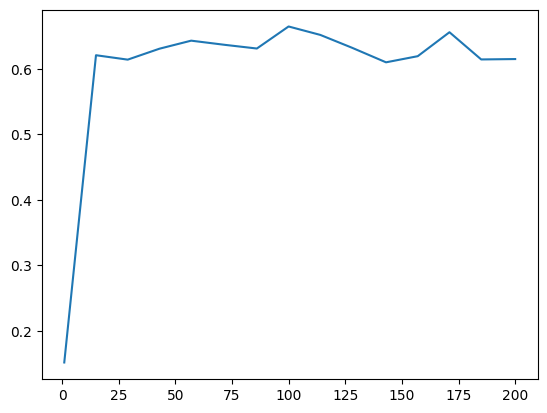

In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


acs = []
dpst = []

for d in np.linspace(1,200,15, dtype=int):
    est_RF_mean = RandomForestClassifier(max_depth=d,random_state=42)

    x = list(data_embs_test[estist].values)
    y = tf.keras.utils.to_categorical(list(data_embs_test['labels'].values))

    s = cross_val_score(est_RF_mean, x,y, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
    acs.append(np.mean(s))
    dpst.append(d)
    
print('max: ',np.max(acs),' - depth: ',dpst[np.argmax(acs)])
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
plt.plot(dpst,acs)

plt.show()

In [96]:
x_RF_train = list(data_embs_train[estist].values)
y_RF_train = tf.keras.utils.to_categorical(list(data_embs_train['labels'].values))
est_RF_mean = RandomForestClassifier(max_depth=dpst[np.argmax(acs)],random_state=42)
est_RF_mean.fit(x_RF_train ,y_RF_train)

x = list(data_embs_test[estist].values)
y = tf.keras.utils.to_categorical(list(data_embs_test['labels'].values))
y_predicted = est_RF_mean.predict(x)

target_names = ['MF1', 'MF2', 'MF3']
print(classification_report(y, y_predicted,target_names=target_names))

              precision    recall  f1-score   support

         MF1       0.87      0.87      0.87        75
         MF2       0.87      0.60      0.71        57
         MF3       1.00      0.81      0.89        52

   micro avg       0.90      0.77      0.83       184
   macro avg       0.91      0.76      0.82       184
weighted avg       0.91      0.77      0.83       184
 samples avg       0.77      0.77      0.77       184



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### KNN

0.44565217391304346


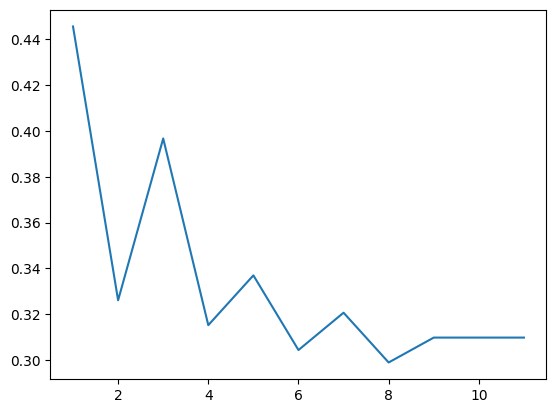

In [101]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

scs = []
dst = []

for d in np.linspace(1,11,10, dtype=int):
    knn_mean = KNeighborsClassifier(n_neighbors = d)


    x = list(data_embs_train[estist].values)
    y = tf.keras.utils.to_categorical(data_embs_train['labels'].values)


    knn_mean.fit(x,y)

    y_pred = knn_mean.predict(list(data_embs_test[estist].values))

    #print("Accuracy: ", accuracy_score(list(data_embs_test['labels'].values), y_pred)*100)
    scs.append(accuracy_score(tf.keras.utils.to_categorical(data_embs_test['labels'].values)
, y_pred))
    dst.append(d)

print(np.max(scs))
plt.plot(dst,scs)    

In [102]:
x_KNN_train = list(data_embs_train[estist].values)
y_KNN_train = tf.keras.utils.to_categorical(list(data_embs_train['labels'].values))
est_KNN_mean = KNeighborsClassifier(n_neighbors = dpst[np.argmax(acs)])
est_KNN_mean.fit(x_KNN_train ,y_KNN_train)

x = list(data_embs_test[estist].values)
y = tf.keras.utils.to_categorical(list(data_embs_test['labels'].values))
y_predicted = est_KNN_mean.predict(x)

target_names = ['MF1', 'MF2', 'MF3']
print(classification_report(y, y_predicted,target_names=target_names))

              precision    recall  f1-score   support

         MF1       0.00      0.00      0.00        75
         MF2       0.00      0.00      0.00        57
         MF3       0.30      1.00      0.46        52

   micro avg       0.30      0.28      0.29       184
   macro avg       0.10      0.33      0.15       184
weighted avg       0.08      0.28      0.13       184
 samples avg       0.28      0.28      0.28       184



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
